<a href="https://colab.research.google.com/github/ArslanSadykov/ML/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D1%8B%D0%BD%D0%BA%D0%B0_%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Шаг 1: Загрузка данных
Загружаем данные и выводим их размеры:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
from scipy import stats
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use('ggplot')


In [ ]:
# Загрузка данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

Размер обучающей выборки: (1460, 81)
Размер тестовой выборки: (1459, 80)


Шаг 2: Разведочный анализ данных (EDA)
Изучаем данные: пропуски, распределение SalePrice и корреляции.


===== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ =====

Базовая информация:
Количество строк: 1460
Количество столбцов: 81

Типы данных:
object     43
int64      35
float64     3
Name: count, dtype: int64

Топ-10 признаков с пропущенными значениями:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

Статистика по числовым признакам:
                     mean          std     min       max
Id             730.500000   421.610009     1.0    1460.0
MSSubClass      56.897260    42.300571    20.0     190.0
LotFrontage     70.049958    24.284752    21.0     313.0
LotArea      10516.828082  9981.264932  1300.0  215245.0
OverallQual      6.099315     1.382997     1.0      10.0

Статистика целевой переменной (SalePrice):
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%    

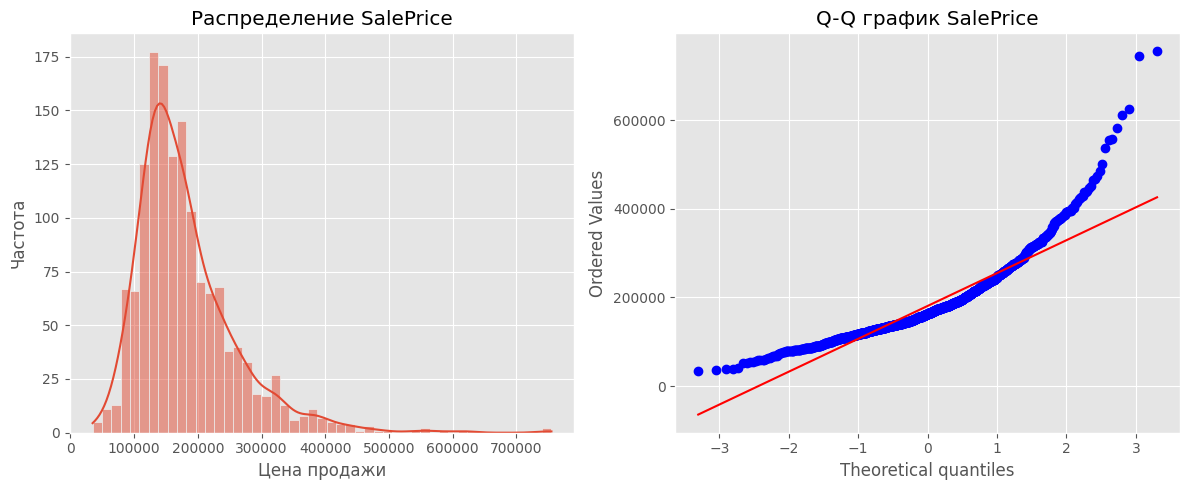

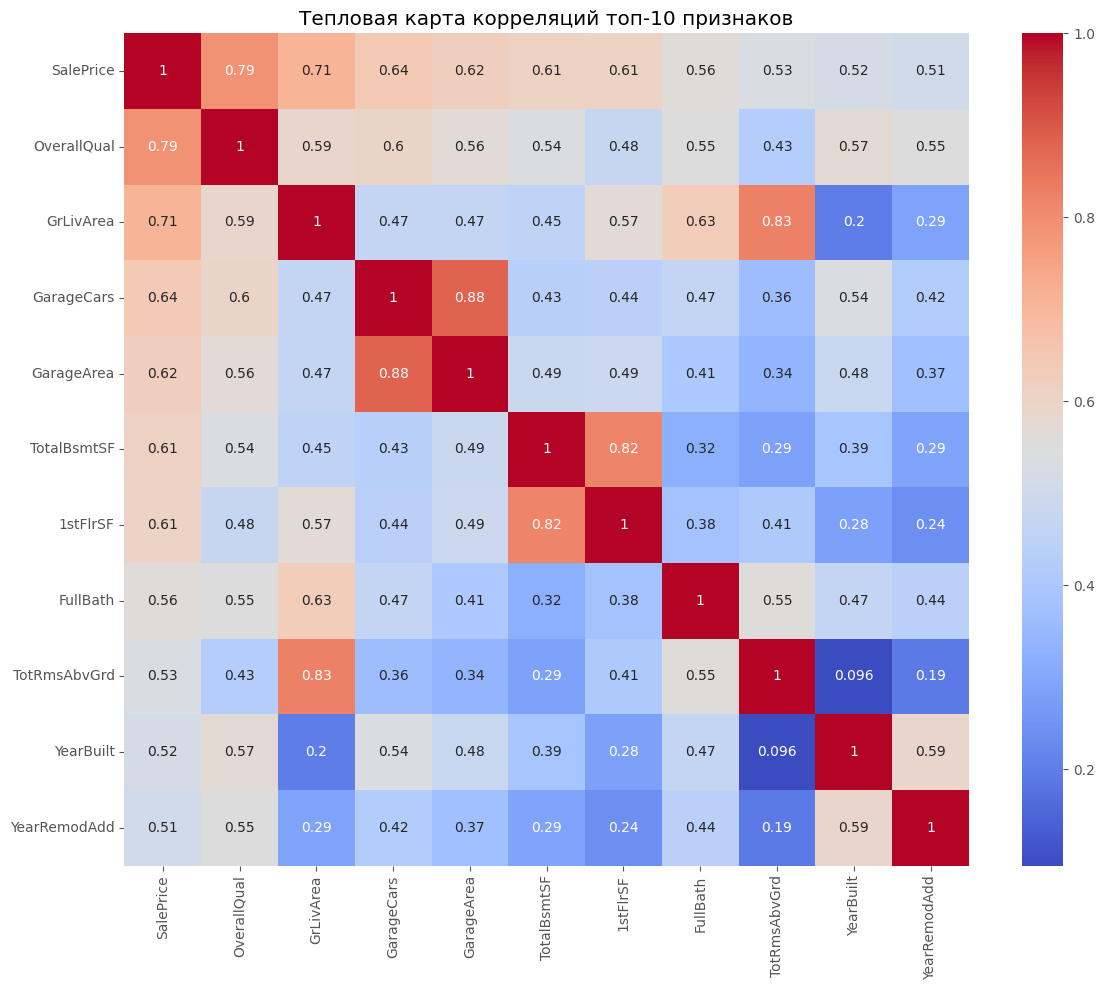

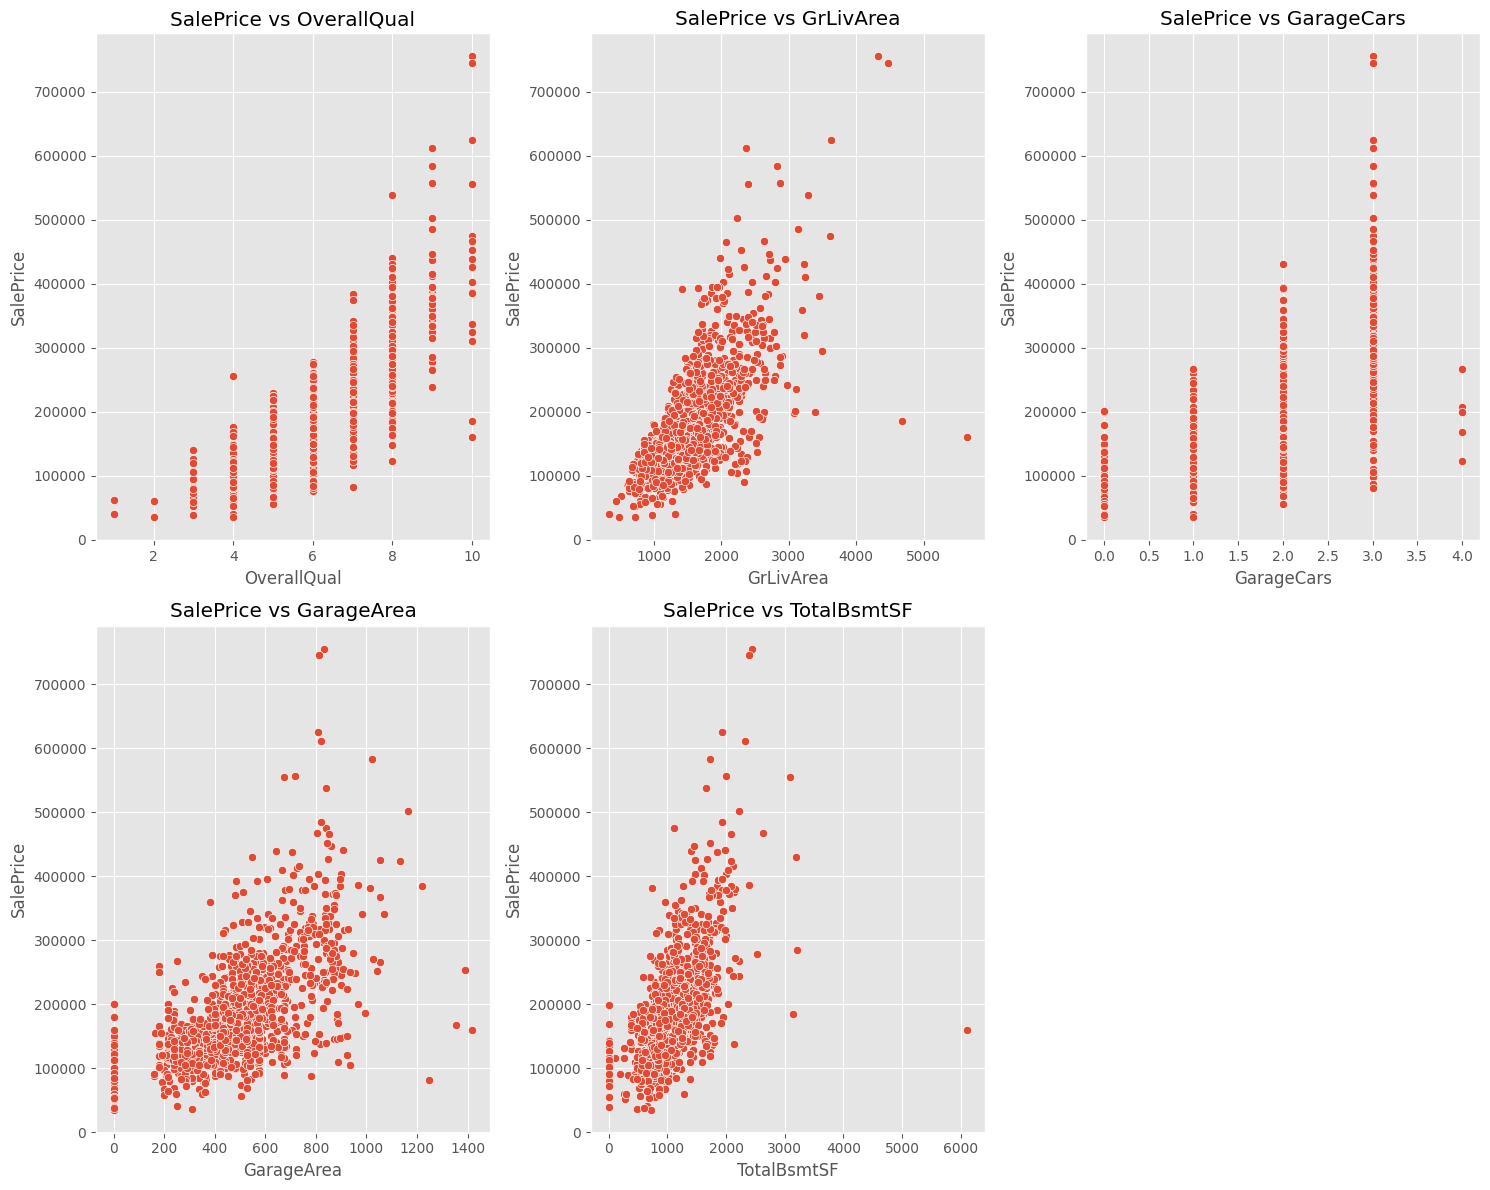

In [ ]:
# Выводим заголовок
print("\n===== РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ =====")

# Базовая информация
print("\nБазовая информация:")
print(f"Количество строк: {train.shape[0]}")
print(f"Количество столбцов: {train.shape[1]}")

# Типы данных
print("\nТипы данных:")
print(train.dtypes.value_counts())

# Пропущенные значения
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nТоп-10 признаков с пропущенными значениями:")
print(missing_values.head(10))

# Статистика числовых признаков
print("\nСтатистика по числовым признакам:")
print(train.describe().T[['mean', 'std', 'min', 'max']].head())

# Анализ SalePrice
print("\nСтатистика целевой переменной (SalePrice):")
print(train['SalePrice'].describe())

# График распределения SalePrice
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True)
plt.title('Распределение SalePrice')
plt.xlabel('Цена продажи')
plt.ylabel('Частота')

# Q-Q график SalePrice
plt.subplot(1, 2, 2)
stats.probplot(train['SalePrice'], plot=plt)
plt.title('Q-Q график SalePrice')
plt.tight_layout()
plt.savefig('saleprice_distribution.png')
print("График сохранен: saleprice_distribution.png")

# Корреляции с SalePrice
numeric_features = train.select_dtypes(include=np.number).columns
correlations = train[numeric_features].corr()['SalePrice'].sort_values(ascending=False)
print("\nТоп-10 корреляций с SalePrice:")
print(correlations.head(11))

# Тепловая карта корреляций
plt.figure(figsize=(12, 10))
top_corr_features = correlations.index[:11]
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляций топ-10 признаков')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
print("Тепловая карта сохранена: correlation_heatmap.png")

# Графики зависимостей
plt.figure(figsize=(15, 12))
for i in range(5):
    feature = correlations.index[i + 1]  # Пропускаем SalePrice
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=train[feature], y=train['SalePrice'])
    plt.title(f'SalePrice vs {feature}')
plt.tight_layout()
plt.show()

Шаг 3: Предобработка данных
Обрабатываем данные: убираем пропуски, кодируем категории, масштабируем числа.


===== ПРЕДОБРАБОТКА ДАННЫХ =====
Удалены признаки с >80% пропусков: ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
Числовых признаков: 37
Категориальных признаков: 39
Размер обработанной обучающей выборки: (1460, 275)
Размер обработанной тестовой выборки: (1459, 275)


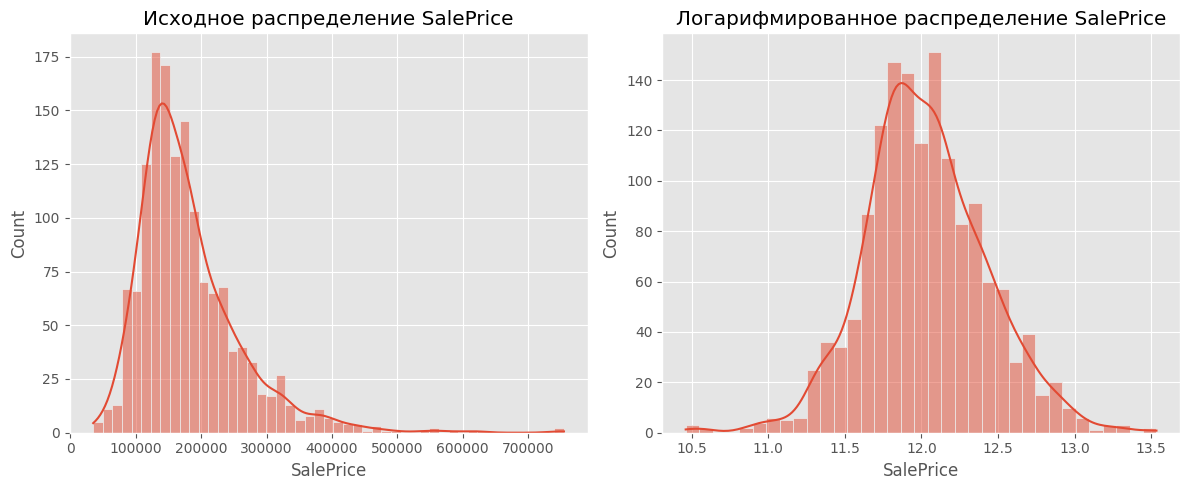

In [ ]:
# Выводим заголовок
print("\n===== ПРЕДОБРАБОТКА ДАННЫХ =====")

# Объединяем train и test
all_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0)
y = train['SalePrice']

# Удаляем признаки с >80% пропусков
high_missing_cols = missing_values[missing_values > 0.8 * len(train)].index.tolist()
if high_missing_cols:
    print(f"Удалены признаки с >80% пропусков: {high_missing_cols}")
    all_data = all_data.drop(high_missing_cols, axis=1)

# Разделяем признаки
numeric_features = all_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()
print(f"Числовых признаков: {len(numeric_features)}")
print(f"Категориальных признаков: {len(categorical_features)}")

# Обрабатываем числовые признаки
imputer_num = SimpleImputer(strategy='median')
numeric_data = imputer_num.fit_transform(all_data[numeric_features])
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

# Обрабатываем категориальные признаки
imputer_cat = SimpleImputer(strategy='most_frequent')
categorical_data = imputer_cat.fit_transform(all_data[categorical_features])
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_data_encoded = encoder.fit_transform(categorical_data)

# Собираем имена признаков
feature_names = (numeric_features +
                 [f"{col}_{cat}" for i, col in enumerate(categorical_features)
                  for cat in encoder.categories_[i]])

# Объединяем обработанные данные
train_size = len(train)
X_processed = np.hstack([numeric_data_scaled, categorical_data_encoded])
X_train_processed = X_processed[:train_size]
X_test_processed = X_processed[train_size:]

# Преобразуем в DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names[:X_train_processed.shape[1]])
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names[:X_test_processed.shape[1]])
print(f"Размер обработанной обучающей выборки: {X_train_df.shape}")
print(f"Размер обработанной тестовой выборки: {X_test_df.shape}")

# Логарифмируем SalePrice
y_log = np.log1p(y)

# Визуализация трансформации
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True)
plt.title('Исходное распределение SalePrice')
plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True)
plt.title('Логарифмированное распределение SalePrice')
plt.tight_layout()
plt.show()

Шаг 4: Анализ важности признаков
Определяем ключевые признаки с помощью RandomForest.


===== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ =====

Топ-20 важнейших признаков:
               Feature  Importance
4          OverallQual    0.544677
16           GrLivArea    0.115551
12         TotalBsmtSF    0.046358
26          GarageCars    0.038627
27          GarageArea    0.024329
13            1stFlrSF    0.021940
9           BsmtFinSF1    0.021400
6            YearBuilt    0.015903
5          OverallCond    0.012519
3              LotArea    0.011969
246   GarageFinish_Unf    0.008339
216       CentralAir_Y    0.008134
7         YearRemodAdd    0.007864
215       CentralAir_N    0.006304
14            2ndFlrSF    0.006245
2          LotFrontage    0.006168
24          Fireplaces    0.006038
11           BsmtUnfSF    0.004944
0                   Id    0.004125
243  GarageType_Detchd    0.003928


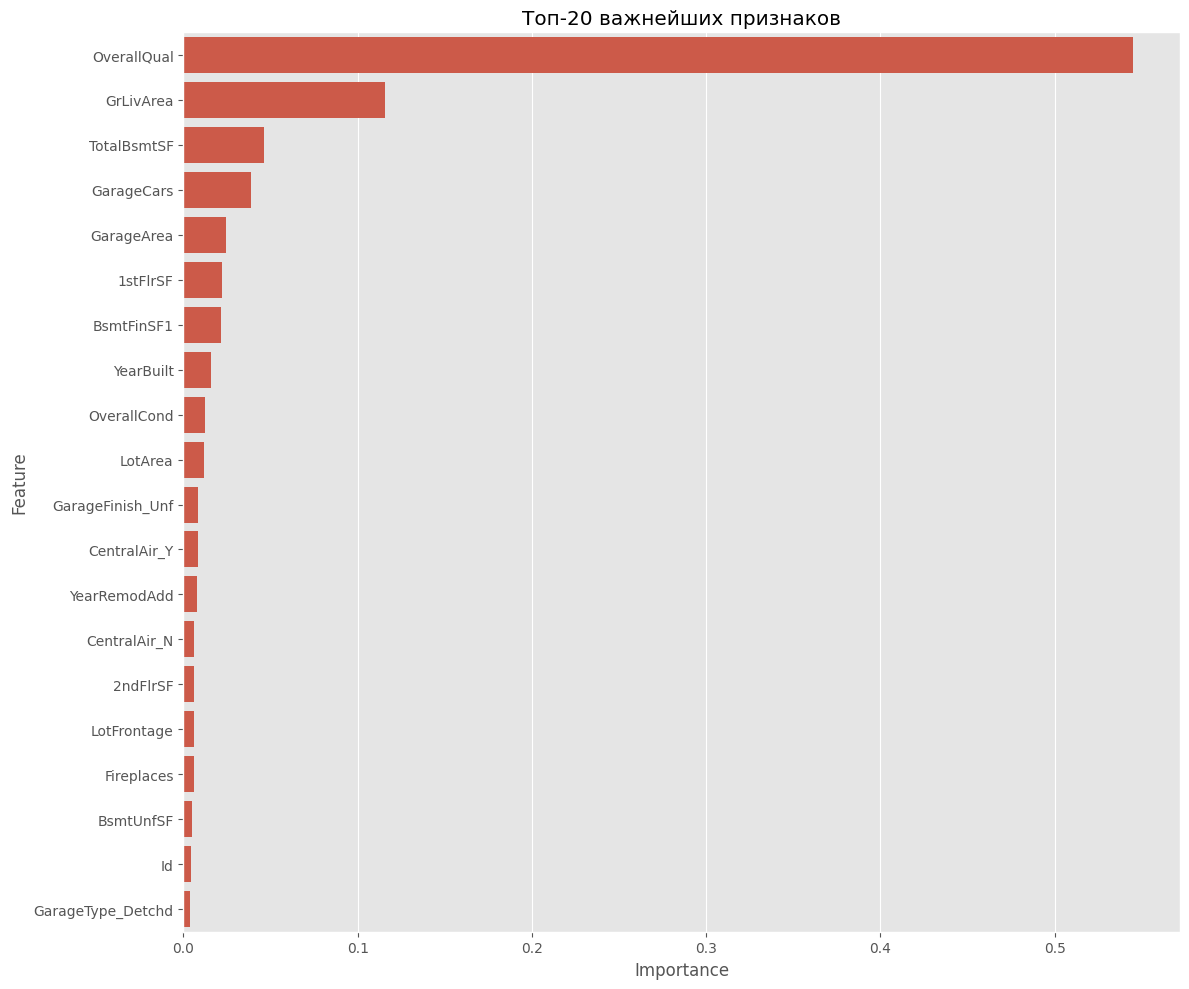

In [ ]:
# Выводим заголовок
print("\n===== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ =====")

# Обучаем RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_df, y_log)

# Получаем важность признаков
feature_importances = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nТоп-20 важнейших признаков:")
print(feature_importances.head(20))

# Визуализация
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Топ-20 важнейших признаков')
plt.tight_layout()
plt.show()

Шаг 5: Уменьшение размерности и визуализация
Снижаем размерность с помощью PCA и t-SNE.


===== УМЕНЬШЕНИЕ РАЗМЕРНОСТИ =====

Топ-10 признаков для PC1:
         Feature       PC1
4    OverallQual  0.277770
16     GrLivArea  0.267520
26    GarageCars  0.253996
27    GarageArea  0.249117
6      YearBuilt  0.242138
19      FullBath  0.240778
12   TotalBsmtSF  0.228851
13      1stFlrSF  0.217704
25   GarageYrBlt  0.216571
7   YearRemodAdd  0.210202

Топ-10 признаков для PC2:
               Feature       PC2
14            2ndFlrSF  0.423830
23        TotRmsAbvGrd  0.342939
21        BedroomAbvGr  0.341439
16           GrLivArea  0.285695
17        BsmtFullBath -0.233754
9           BsmtFinSF1 -0.230339
20            HalfBath  0.216293
6            YearBuilt -0.193751
111  HouseStyle_1Story -0.179970
22        KitchenAbvGr  0.165733

t-SNE анализ (может занять время)...
t-SNE завершен за 8.62 секунд


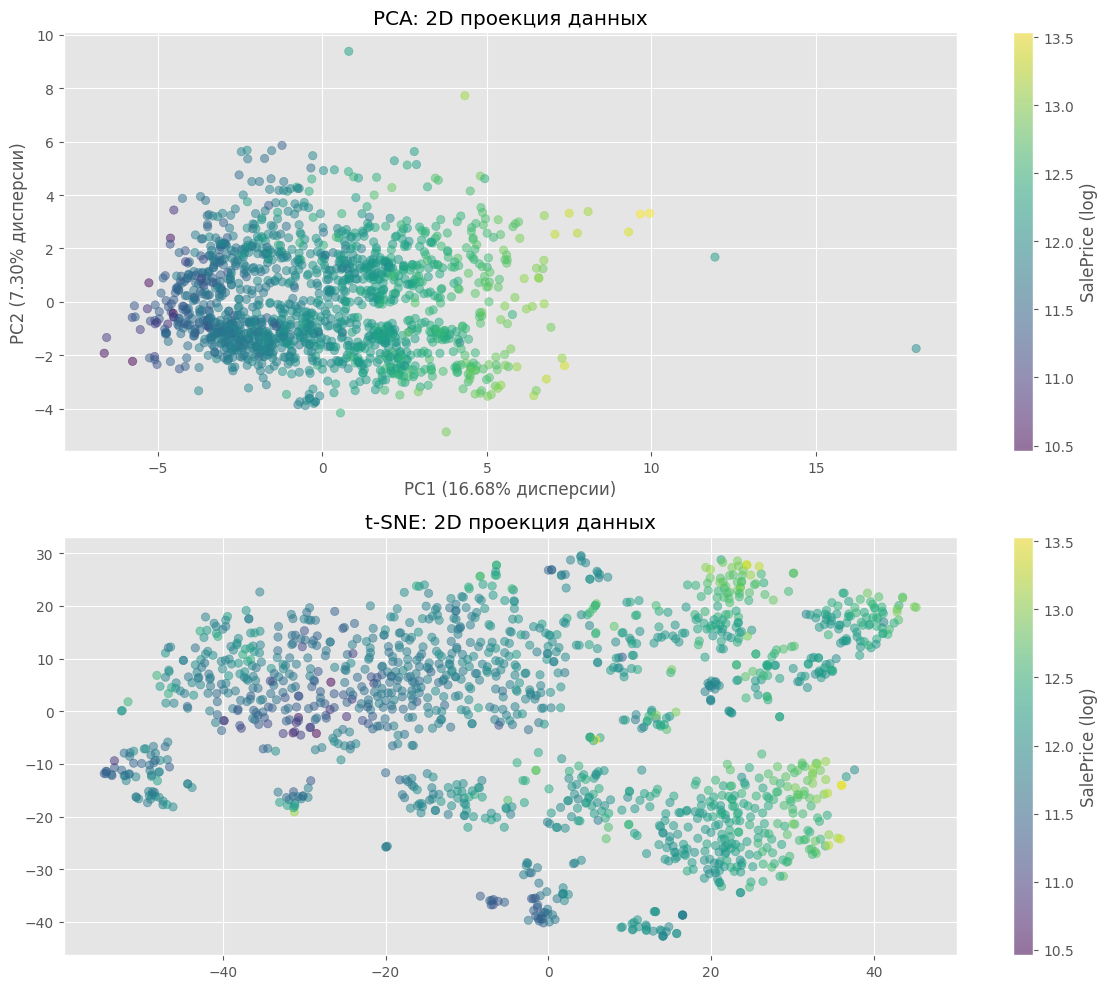

In [ ]:
# Выводим заголовок
print("\n===== УМЕНЬШЕНИЕ РАЗМЕРНОСТИ =====")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_df)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_log, cmap='viridis', alpha=0.5)
plt.colorbar(label='SalePrice (log)')
plt.title('PCA: 2D проекция данных')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')

# Анализ компонент PCA
component_df = pd.DataFrame({
    'Feature': X_train_df.columns,
    'PC1': pca.components_[0],
    'PC2': pca.components_[1]
})
print("\nТоп-10 признаков для PC1:")
print(component_df.sort_values('PC1', key=abs, ascending=False).head(10)[['Feature', 'PC1']])
print("\nТоп-10 признаков для PC2:")
print(component_df.sort_values('PC2', key=abs, ascending=False).head(10)[['Feature', 'PC2']])

# t-SNE
print("\nt-SNE анализ (может занять время)...")
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_df)
print(f"t-SNE завершен за {time.time() - start_time:.2f} секунд")

plt.subplot(2, 1, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_log, cmap='viridis', alpha=0.5)
plt.colorbar(label='SalePrice (log)')
plt.title('t-SNE: 2D проекция данных')
plt.tight_layout()
plt.show()

Шаг 6: Выбор признаков
Отбираем топ-50 признаков.

In [ ]:
# Выводим заголовок
print("\n===== ВЫБОР ПРИЗНАКОВ =====")

# Выбираем топ-50 признаков
top_features = feature_importances.head(50)['Feature'].values
X_train_selected = X_train_df[top_features]

print(f"Выбрано {len(top_features)} признаков из {X_train_df.shape[1]}")
print(f"Размер выборки после отбора: {X_train_selected.shape}")


===== ВЫБОР ПРИЗНАКОВ =====
Выбрано 50 признаков из 275
Размер выборки после отбора: (1460, 50)


Шаг 7: Обучение модели
Обучаем RandomForest и оцениваем его.


===== ОБУЧЕНИЕ МОДЕЛИ =====
Размер обучающей выборки: (1168, 50)
Размер проверочной выборки: (292, 50)
RMSE: 26244.15
R^2: 0.8791


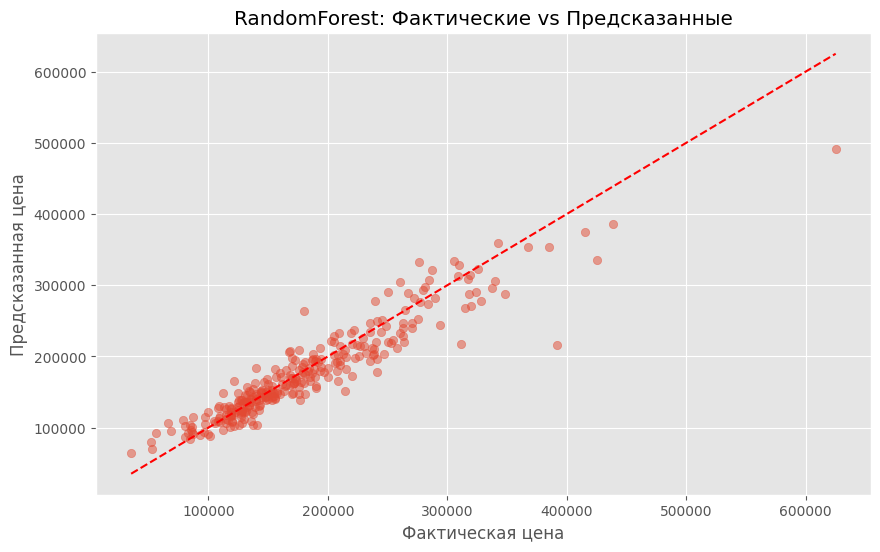

In [ ]:
# Выводим заголовок
print("\n===== ОБУЧЕНИЕ МОДЕЛИ =====")

# Разделяем данные
train_idx = np.random.choice(X_train_selected.index, size=int(0.8 * len(X_train_selected)), replace=False)
val_idx = np.setdiff1d(X_train_selected.index, train_idx)
X_train_split = X_train_selected.loc[train_idx]
X_val_split = X_train_selected.loc[val_idx]
y_train_split = y_log.loc[train_idx]
y_val_split = y_log.loc[val_idx]

print(f"Размер обучающей выборки: {X_train_split.shape}")
print(f"Размер проверочной выборки: {X_val_split.shape}")

# Обучаем RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_split, y_train_split)

# Предсказываем
y_val_pred = rf_model.predict(X_val_split)

# Оцениваем
y_val_actual = np.expm1(y_val_split)
y_val_pred_actual = np.expm1(y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_actual))
r2 = r2_score(y_val_actual, y_val_pred_actual)

print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.4f}")

# Визуализация предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, y_val_pred_actual, alpha=0.5)
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--')
plt.xlabel('Фактическая цена')
plt.ylabel('Предсказанная цена')
plt.title('RandomForest: Фактические vs Предсказанные')
plt.show()

Шаг 8: Итоговый анализ
Подводим итоги.

In [ ]:
# Выводим заголовок
print("\n===== ИТОГОВЫЙ АНАЛИЗ =====")

print(f"\nРезультаты модели RandomForest:")
print(f"R^2: {r2:.4f}, RMSE: {rmse:.2f}")

print("\nТоп-10 важных признаков:")
print(feature_importances.head(10))

print("\nЗАКЛЮЧЕНИЕ:")
print("1. Данные загружены и обработаны.")
print("2. Выявлены ключевые признаки.")
print("3. Модель обучена и оценена.")


===== ИТОГОВЫЙ АНАЛИЗ =====

Результаты модели RandomForest:
R^2: 0.8791, RMSE: 26244.15

Топ-10 важных признаков:
        Feature  Importance
4   OverallQual    0.544677
16    GrLivArea    0.115551
12  TotalBsmtSF    0.046358
26   GarageCars    0.038627
27   GarageArea    0.024329
13     1stFlrSF    0.021940
9    BsmtFinSF1    0.021400
6     YearBuilt    0.015903
5   OverallCond    0.012519
3       LotArea    0.011969

ЗАКЛЮЧЕНИЕ:
1. Данные загружены и обработаны.
2. Выявлены ключевые признаки.
3. Модель обучена и оценена.


В ходе исследования набора данных Ames Housing для предсказания цен на недвижимость были получены следующие результаты:

- **Анализ данных (EDA)**: Выявлены ключевые признаки, влияющие на `SalePrice`: `OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea` и `TotalBsmtSF`. Они имеют сильную положительную корреляцию с ценой, что подтверждают диаграммы рассеяния и тепловая карта
- **Предобработка**: Пропуски обработаны, категориальные признаки закодированы, числовые — масштабированы. `SalePrice` логарифмирован для нормализации распределения
- **Важность признаков**: RandomForest показал, что `OverallQual` (54.47%) и `GrLivArea` (11.56%) — самые значимые факторы
- **Визуализация**: PCA (16.68% и 7.03% дисперсии) и t-SNE выявили кластеры в данных
- **Модель**: RandomForest достиг R² = 0.8791 и RMSE = 26,244.15 USD, что говорит о высокой точности предсказаний

**Вывод**: Исследование выявило основные факторы, влияющие на цену жилья, и подтвердило эффективность RandomForest для её предсказания